# Prédiction de la performance d'un joueur

Ce notebook présente notre projet de prédicition de la performance d'un joueur à partir de ses statistiques de jeu sur la saison et en cobnsidérant les transferts.

# Première Partie : Scrapping des données

Exécuter ce code pour importer toutes les données scrapées ci-dessous

In [40]:
import pickle,zlib,pandas as pd

player_stats_fbref=pickle.loads(zlib.decompress(open('fbref_data/compressed_player_stats_fbref_1.bin','rb').read()))
player_stats_fbref.update(pickle.loads(zlib.decompress(open('fbref_data/compressed_player_stats_fbref_2.bin','rb').read())))
player_stats_fbref=pd.DataFrame(player_stats_fbref).transpose()
player_stats_fbref=player_stats_fbref.sort_index(axis=1,ascending=False)
def change_minutes_type(entry):
    "Numérise l'entrée associée au minutes jouées"
    try:
        entry['minutes']=float(entry['minutes'].replace(',',''))
        return entry
    except:
        return entry



player_stats_fbref=player_stats_fbref.map(change_minutes_type)

teams_fbref=pickle.load(open('fbref_data/teams_fbref.pkl','rb'))

glossary=pd.read_csv('fbref_data/Glossaire_FBREF.csv')


player_stats_tm=pd.DataFrame(pickle.load(open('tm_data/player_stats_tm.pkl','rb'))).transpose()


transfer_history=pickle.load(open('tm_data/transfer_history.pkl','rb'))
player_ratings=pd.read_csv('sf_data/player_ratings.csv',index_col=0)



global_team_stats_fbref=pd.DataFrame(pickle.load(open('fbref_data/global_team_stats_fbref.pkl','rb'))).transpose()
global_team_stats_fbref.columns=list(map(lambda s:f'{s}-{s+1}',global_team_stats_fbref.columns))
na_global_team_stats=global_team_stats_fbref.isna()




# Données FBREF

## Dans cette partie on va extraire les données sur le site Fbref : https://fbref.com/en/ relatant de la performance des joueurs $\textit{ie}$ leurs métriques et de la performance des équipes. Tout cela dans les 5 grands championnats et sur les 10 dernières années pour se constuire une base de données solide

### Extraction des données joueurs: On localise d'abord leurs données en parcourant les différentes équipes 

In [ ]:
!pip3 install lxml

In [241]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import time

def get_teams_fbref(champ,season):
    "renvoie les équipes sur fbref associées au championnat champ lors de season"
    #Code HTML de la page fbref de la saison season pour le championnat champ
    url=f'https://fbref.com/en/comps/{champ}/{season}-{season+1}/{season}-{season+1}-any-Stats'
    html = requests.get(url).text
    soup = BeautifulSoup(html, 'lxml')
    
    # Trouver le classement et toutes les lignes du tableau
    table=soup.find_all('table')[0]
    rows=table.find_all('tr')[1:]
    res={}
    
    #Faire un dicto avec toutes les équipes et leur id (utile pour après)
    for row in rows:
        link=row.find('a').get('href')
        id=link.split('/')[3]
        name=row.find('a').text
        res[name]=id
    return res

    

On trouve toutes les équipes pour tous les championnats sur les 10 dernières années

In [ ]:
championships={'GB1':9,'IT1':11,'ES1':12,'FR1':13,'L1':20}

#2 formats différents qu'on va réutiliser
years=[2024-i for i in range(10)]

seasons=[f'{n}-{n+1}' for n in [2024-i for i in range(10)]]

teams_fbref={}


for c in championships.keys():
    teams_fbref[c]={}
    for year in years:
        print(c,year)
        teams_fbref[c][year]=get_teams_fbref(championships[c],year)
        # le time sleep est très important ici car sinon on se fait bannir du site pendant une heure 
        time.sleep(4)


Exemple avec les équipes anglaises de cette année, on a un dictionnaire avec tous les IDS

In [49]:
teams_fbref['GB1'][2024]

{'Liverpool': '822bd0ba',
 'Chelsea': 'cff3d9bb',
 'Arsenal': '18bb7c10',
 "Nott'ham Forest": 'e4a775cb',
 'Manchester City': 'b8fd03ef',
 'Aston Villa': '8602292d',
 'Bournemouth': '4ba7cbea',
 'Fulham': 'fd962109',
 'Brighton': 'd07537b9',
 'Tottenham': '361ca564',
 'Brentford': 'cd051869',
 'Newcastle Utd': 'b2b47a98',
 'Manchester Utd': '19538871',
 'West Ham': '7c21e445',
 'Crystal Palace': '47c64c55',
 'Everton': 'd3fd31cc',
 'Leicester City': 'a2d435b3',
 'Ipswich Town': 'b74092de',
 'Wolves': '8cec06e1',
 'Southampton': '33c895d4'}

Sauvegarde du dictionnaire des équipes

In [425]:
import pickle
with open('teams_fbref.pkl','wb') as file: 
    pickle.dump(teams_fbref,file)

Cette partie peut être ignorée, les entrées du glossaires ne correspondent pas exactement aux noms des statistiques dans le dataframe

### Glossaire pour expliquer les acronymes des différentes stats

Ici on doit utiliser Selenium car on doit glisser la souris sur des boutons, qui font apparaître du code html 

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time



#Sélecteurs de tous les bouttons

button_paths=['#stats_shooting_dom_lg_sh','#stats_passing_dom_lg_sh', \
              '#stats_passing_types_dom_lg_sh','#stats_gca_dom_lg_sh', \
                '#stats_playing_time_dom_lg_sh','#stats_possession_dom_lg_sh', '#stats_misc_dom_lg_sh']

button_paths=[button+f' > div > ul > li:nth-child({1 if button_paths.index(button)!=0 else 2}) > button' for button in button_paths]

#À titre d'exemple (on aurait pu prendre un autre joueur)

url=f'https://fbref.com/en/players/e06683ca/Virgil-van-Dijk'



driver=webdriver.Chrome()
driver.implicitly_wait(10)
driver.get(url)

glossaries=[]


for button in button_paths:
  
  # Scroller jusqu'au boutton glossaire, le code ajustera jusqu'à trouver le boutton par lui même
    while(True):
      try:
        driver.find_element(By.CSS_SELECTOR,button).click()
        break
      except:
        pass
    glossaries.append(([x.text for x in driver.find_elements(By.XPATH,'//*[@id="sr_glossary"]')]))
    

In [ ]:
glossary={}
for i in range(len(glossaries)):
    stats=[s.split('\n')[-1] for s in glossaries[i][0].split('--')][:-1 ]
    explanations=[s.split('\n')[0] for s in glossaries[i][0].split('--')][1:]
    stats=list(map(lambda s:s.strip(),stats))
    explanations=list(map(lambda s:s.split(':')[0].strip(),explanations))
    glossary.update(zip(stats,explanations))
    

Sauvegarde du glossaire

In [40]:
import pandas as pd 
glossary=pd.Series(glossary)
glossary.to_csv('Glossaire_FBREF.csv')

In [389]:
glossary.head(10)

Season                            Season
Age                  Age at season start
Country    Flag and name of the country.
Comp                         Competition
LgRank       Squad finish in competition
90s                           90s Played
Gls                                Goals
Sh                            GCA (Shot)
SoT                      Shots on Target
SoT%                   Shots on Target %
dtype: object

### On utilise les ids précédemment obtenus sur les équipes pour se rendre à chacune de leurs pages, puis on accède aux pages de chaque joueur de l'équipe et on extrait les statistiques du joueur

In [71]:
def get_player_stats_fbref(player_id):
    "Retourne les statistiques pour le joueur d'id player_id sous format de dictionnaire"
    url=f'https://fbref.com/en/players/{player_id}/'
    html = requests.get(url).text
    time.sleep(4)
    soup = BeautifulSoup(html, 'lxml')
    res={}
    #Données sur taille poids pied fort âge et pays
    
    
    
    # Plusieurs try car il est possible par exemple qu'il y ait une entrée 'physical' mais pas d'entrée 'foot'
    metadata=soup.find('div',id='meta')
    try:
        physical=list(map(lambda x:x.text,metadata.find_all('span')[1:3]))
        physical[0],physical[1]=float(physical[0].split('cm')[0]),float(physical[1].split('kg')[0])
    except:
        physical=['','']
    try:
        foot=metadata.find('strong',string='Footed:').next_sibling.strip()
    except:
        foot=''
    try:
        age=2025-int(metadata.find('span',id='necro-birth').get('data-birth').split('-')[0])
    except:
        age=''
    try:
        country=metadata.find('a').text
    except:
        country=''
    meta=physical+[foot,age,country]
    
    
    
    
    attributes=['height','weight','preferred foot','age','country']
    
    res['meta']=dict(zip(attributes,meta))
    
    
    
    
    
    std_rows=soup.find('table',id="stats_standard_dom_lg")
    
    try:
        std_rows=std_rows.select('tr[id="stats"]')
    except:
        return res
    
    
    # Données sur les antécédents en club, pays, championnats
    teams,countries,champs=[],[],[]
    for row in std_rows:
        teams.append(row.select_one(('td[data-stat="team"]')).text)
        countries.append((row.select_one(('td[data-stat="country"]'))).text.split(' ')[-1] )
        champs.append(row.select_one(('td[data-stat="comp_level"]')).text.split('1. ')[-1])
        
    # Extraction des stats sur tous les aspects du jeu
    
    
    #On différencie les Gardiens
    
    try:
        if soup.find(string='Position:').next_element[1]=='G':
            table_ids=["keeper","keeper","passing","passing_types","possession","playing_time","misc"]
        else:
            table_ids=["shooting","passing","passing_types","gca","defense","possession","playing_time","misc"]
    except:
        table_ids=["shooting","passing","passing_types","gca","defense","possession","playing_time","misc"]
    table_ids=list(map(lambda s:'stats_'+s+'_dom_lg',table_ids))
    
    
    
    for id in table_ids:
        
        
        #Certains joueurs n'ont pas des tableaux pour tous les aspects du jeu
        try:
            table=soup.find('table',id=id)
            header=table.find_all('tr')[1]
            cols=[x.get('data-stat') for x in header.find_all('th')][1:]
            for row in table.find_all('tr',id="stats"):
                year=row.select_one('th[data-stat="year_id"]').text
                if year not in res.keys():
                    res[year]={}
                for col in cols[:-1]:
                    res[year][col]=row.select_one(f'td[data-stat="{col}"]').text
        except:
            pass
        
    # Transformation en flottants pour les nombres
    for y in res.keys():
        
        for c in res[y].keys():
            try:
                #le replace pour les minutes qui ont une , au lieu de .
                res[y][c]=float(res[y][c].replace('-','.'))
            except:
                pass
    
    return res
        
    
def get_team_stats_fbref(team_id,season,champ,player_dict={},display_flag=False):
    url=f'https://fbref.com/en/squads/{team_id}/{season}-{season+1}/any'
    html = requests.get(url).text
    time.sleep(4)
    soup = BeautifulSoup(html, 'lxml')
    
    
    table=soup.find('table',id=f"stats_standard_{championships[champ]}").find('tbody')
    for row in table.find_all('tr'):
        name=row.find('a').text
        if name not in player_dict.keys():
            if display_flag:
                print(name)
            player_dict[name]=get_player_stats_fbref(row.find('a').get('href').split('/')[3])
    
    
    
    
    
    
    
    

Itération sur l'ensemble des championnats,saisons

In [ ]:
player_stats_fbref={}

#Seen pour relancer sans devoir reparcourir toutes les équipes si erreur
seen=set()
for country in teams_fbref.keys():
    for year in teams_fbref[country].keys():
        for team in teams_fbref[country][year].keys():
            if (team,year) not in seen:
                print(team,year)
                get_team_stats_fbref(teams_fbref[country][year][team],year,country,player_stats_fbref)
                seen.add((team,year))
                
                

Compression pour pouvoir mettre les données sur Github car la taille des fichiers dépasse 25 MB

In [420]:
import zlib
n=len(player_stats_fbref)

#Séparation en 2 pour respecter la limite des 25 Mb de Github
player_stats_fbref_1=dict(list(player_stats_fbref.items())[int(n/2):])
player_stats_fbref_2=dict(list(player_stats_fbref.items())[:int(n/2)])

compressed_player_stats_fbref_1=zlib.compress(pickle.dumps(player_stats_fbref_1))
compressed_player_stats_fbref_2=zlib.compress(pickle.dumps(player_stats_fbref_2))


with open('compressed_player_stats_fbref_1.bin', 'wb') as f:
    f.write(compressed_player_stats_fbref_1)
with open('compressed_player_stats_fbref_2.bin', 'wb') as f:
    f.write(compressed_player_stats_fbref_2)



In [27]:


player_stats_fbref=pd.DataFrame(player_stats_fbref).transpose()
player_stats_fbref=player_stats_fbref.sort_index(axis=1,ascending=True)

In [50]:
player_stats_fbref.head()

,meta,2024-2025,2024,2023-2024,2023,2022-2023,2022,2021-2022,2021,2020-2021,...,1999-2000,1999,1998-1999,1998,1997-1998,1996-1997,1995-1996,1994-1995,1993-1994,1992-1993
César Fernández,"{'height': '', 'weight': '', 'preferred foot':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yoel Lago,"{'height': '', 'weight': '', 'preferred foot':...","{'age': 20.0, 'team': 'Celta Vigo', 'country':...",NaN,"{'age': 19.0, 'team': 'Celta Vigo', 'country':...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marc Vidal,"{'height': '', 'weight': '', 'preferred foot':...","{'age': 24.0, 'team': 'Celta Vigo', 'country':...",NaN,NaN,NaN,"{'age': 22.0, 'team': 'FC Andorra', 'country':...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rui Silva,"{'height': 189.0, 'weight': 84.0, 'preferred f...","{'age': 30.0, 'team': 'Betis', 'country': 'es ...",NaN,"{'age': 29.0, 'team': 'Betis', 'country': 'es ...",NaN,"{'age': 28.0, 'team': 'Betis', 'country': 'es ...",NaN,"{'age': 27.0, 'team': 'Betis', 'country': 'es ...",NaN,"{'age': 26.0, 'team': 'Granada', 'country': 'e...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abde Ezzalzouli,"{'height': 177.0, 'weight': 73.0, 'preferred f...","{'age': 22.0, 'team': 'Betis', 'country': 'es ...",NaN,"{'age': 21.0, 'team': 'Betis', 'country': 'es ...",NaN,"{'age': 20.0, 'team': 'Osasuna', 'country': 'e...",NaN,"{'age': 19.0, 'team': 'Barcelona', 'country': ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Il est assez difficile de voir ce qui se passe mais les données sont rangées de la façon suivante: Pour chaque case du dataframe, on a un dictionnaire associé à un joueur pour une saison, et dans ce dictionnaire, on trouve les métriques du joueur pour la saison , $\textit{ie}$ , les buts, passes décisives... Il y a également une colonne 'meta' qui donne, le bon pied, le poids...

Exemple

In [14]:
list(player_stats_fbref.loc['Mohamed Salah','2024-2025'].items())[:10]

[('age', 32.0),
 ('team', 'Liverpool'),
 ('country', 'eng ENG'),
 ('comp_level', '1. Premier League'),
 ('lg_finish', '1st'),
 ('minutes_90s', 13.6),
 ('goals', 13.0),
 ('shots', 43.0),
 ('shots_on_target', 23.0),
 ('shots_on_target_pct', 53.5)]

In [15]:
player_stats_fbref.loc['Mohamed Salah','meta']

{'height': 175.0,
 'weight': 71.0,
 'preferred foot': 'Left',
 'age': 33.0,
 'country': 'Egypt'}

Cette base de données va être très utile pour directement savoir si un joueur a bien une entrée pour une certaine saison

In [ ]:
na_player_stats_fbref=player_stats_fbref.isna()

## Données d'ensemble des équipes

In [20]:


def get_global_team_stats_fbref(team_id,season):
    "Remplis aggregation_dict avec les différentes statistiques et la fonction d'aggrégation pour chaque"
    html=requests.get(f'https://fbref.com/en/squads/{team_id}/{season}/team-Stats').text
    soup=BeautifulSoup(html,'lxml')
    time.sleep(4)
    
    #Tableaux avec des statistiques détaillées
    tables=soup.find_all('table')[2:-2]


    res={}

    for table in tables:
        
        
        
        # Ligne d'aggrégation (Squad total)
        row=table.find('tfoot').find('tr')
        
        for col in row.find_all('td'):
            stat_name=col.get('data-stat')
            
            # Celles qui sont disponibles
            
            try:
                res[stat_name]=float(col.text.replace(',',''))
            except:
                continue
            
    
            
            
    return res
            
            
list(get_global_team_stats_fbref('53a2f082','2024-2025').items())[:10]    
        
    


[('age', 27.5),
 ('gk_games', 18.0),
 ('gk_games_starts', 18.0),
 ('gk_minutes', 1620.0),
 ('minutes_90s', 18.0),
 ('gk_goals_against', 18.0),
 ('gk_goals_against_per90', 1.0),
 ('gk_shots_on_target_against', 51.0),
 ('gk_saves', 34.0),
 ('gk_save_pct', 64.7)]

In [51]:
global_team_stats_fbref={}

seen=set()
for champ,year,team in tqdm([(champ,year,team) for champ in teams_fbref.keys() for year in teams_fbref[champ].keys() for team in teams_fbref[champ][year].keys()]):
            if (champ,year,team) not in seen:
                if team not in global_team_stats_fbref.keys():
                    global_team_stats_fbref[team]={}
                    
                d=get_global_team_stats_fbref(teams_fbref[champ][year][team],f'{year}-{year+1}')
                if d=={}:
                    print(f'No result for : {team} at year {year}')
                global_team_stats_fbref[team][year]=d
                seen.add((champ,year,team))
                
                

100%|██████████| 976/976 [1:44:54<00:00,  6.45s/it]


Sauvegarde des données globales des équipes

In [57]:
pickle.dump(global_team_stats_fbref,open('global_team_stats_fbref.pkl','wb'))

In [81]:
global_team_stats_fbref=pd.DataFrame(global_team_stats_fbref)
global_team_stats_fbref=global_team_stats_fbref.transpose()
global_team_stats_fbref.columns=list(map(lambda s:f'{s}-{s+1}',global_team_stats_fbref.columns))
global_team_stats_fbref.head()

,2024-2025,2023-2024,2022-2023,2021-2022,2020-2021,2019-2020,2018-2019,2017-2018,2016-2017,2015-2016
Liverpool,"{'age': 27.5, 'gk_games': 17.0, 'gk_games_star...","{'age': 26.3, 'gk_games': 38.0, 'gk_games_star...","{'age': 27.4, 'gk_games': 38.0, 'gk_games_star...","{'age': 27.7, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.8, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.6, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.1, 'gk_games': 38.0, 'gk_games_star...","{'age': 25.6, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.1, 'gk_games': 38.0, 'gk_games_star...","{'age': 25.2, 'gk_games': 38.0, 'gk_games_star..."
Chelsea,"{'age': 24.0, 'gk_games': 18.0, 'gk_games_star...","{'age': 24.2, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.3, 'gk_games': 38.0, 'gk_games_star...","{'age': 27.4, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.0, 'gk_games': 38.0, 'gk_games_star...","{'age': 25.5, 'gk_games': 38.0, 'gk_games_star...","{'age': 27.3, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.7, 'gk_games': 38.0, 'gk_games_star...","{'age': 27.2, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.8, 'gk_games': 38.0, 'gk_games_star..."
Arsenal,"{'age': 26.4, 'gk_games': 17.0, 'gk_games_star...","{'age': 25.0, 'gk_games': 38.0, 'gk_games_star...","{'age': 24.7, 'gk_games': 38.0, 'gk_games_star...","{'age': 24.4, 'gk_games': 38.0, 'gk_games_star...","{'age': 25.9, 'gk_games': 38.0, 'gk_games_star...","{'age': 25.8, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.7, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.8, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.9, 'gk_games': 38.0, 'gk_games_star...","{'age': 27.0, 'gk_games': 38.0, 'gk_games_star..."
Nott'ham Forest,"{'age': 26.9, 'gk_games': 18.0, 'gk_games_star...","{'age': 25.7, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.5, 'gk_games': 38.0, 'gk_games_star...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
Manchester City,"{'age': 27.7, 'gk_games': 18.0, 'gk_games_star...","{'age': 26.6, 'gk_games': 38.0, 'gk_games_star...","{'age': 27.2, 'gk_games': 38.0, 'gk_games_star...","{'age': 27.0, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.1, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.9, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.7, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.4, 'gk_games': 38.0, 'gk_games_star...","{'age': 28.5, 'gk_games': 38.0, 'gk_games_star...","{'age': 28.3, 'gk_games': 38.0, 'gk_games_star..."


C'est le même principe qu'avec le df player_stats_fbref

#### Quelques statistiques du Real Madrid lors de la saison 2017-2018

In [76]:
import random
random.sample(list(global_team_stats_fbref.loc['Real Madrid','2017-2018'].items()),k=10)

[('progressive_passes_received', 2370.0),
 ('tackles_won', 470.0),
 ('games_starts', 418.0),
 ('gca_passes_live', 121.0),
 ('passes_into_penalty_area', 512.0),
 ('points_per_game', 2.0),
 ('passes_dead', 1895.0),
 ('gk_passes_completed_launched', 105.0),
 ('fouls', 436.0),
 ('passes_progressive_distance', 120201.0)]

In [82]:
na_global_team_stats=global_team_stats_fbref.isna()
na_global_team_stats.head()

,2024-2025,2023-2024,2022-2023,2021-2022,2020-2021,2019-2020,2018-2019,2017-2018,2016-2017,2015-2016
Liverpool,False,False,False,False,False,False,False,False,False,False
Chelsea,False,False,False,False,False,False,False,False,False,False
Arsenal,False,False,False,False,False,False,False,False,False,False
Nott'ham Forest,False,False,False,True,True,True,True,True,True,True
Manchester City,False,False,False,False,False,False,False,False,False,False


#### Quelques statistiques du Real Madrid lors de la saison 2017-2018

In [76]:
import random
random.sample(list(global_team_stats_fbref.loc['Real Madrid','2017-2018'].items()),k=10)

[('progressive_passes_received', 2370.0),
 ('tackles_won', 470.0),
 ('games_starts', 418.0),
 ('gca_passes_live', 121.0),
 ('passes_into_penalty_area', 512.0),
 ('points_per_game', 2.0),
 ('passes_dead', 1895.0),
 ('gk_passes_completed_launched', 105.0),
 ('fouls', 436.0),
 ('passes_progressive_distance', 120201.0)]

#### Données fbref stockées dans un dossier propre

In [37]:
!mkdir fbref_data
!mv compressed_player_stats_fbref_1.bin compressed_player_stats_fbref_2.bin Glossaire FBREF Glossaire_FBREF.csv teams_fbref.pkl global_team_stats_fbref.pkl fbref_data


# Données Transfermarkt

## Dans cette section on va scrapper les données sur le site https://www.transfermarkt.com relatant de la valeur marchande des joueurs, leur postes et l'historique de transfer de chaque équipe

## Données sur les joueurs

###  (On récupère évolution de la valeur marchande + postes)

In [ ]:
!pip3 install rapidfuzz

Pour accéder rapidement à la liste des équipes sans devoir parcourir chaque championnat, saison

In [20]:

teams_fbref_list=[]
for k,v in teams_fbref.items():
    for kk,vv in v.items():
        teams_fbref_list+=(list(vv.keys()))

In [50]:
teams_fbref_list[:10]

['Liverpool',
 'Chelsea',
 'Arsenal',
 "Nott'ham Forest",
 'Manchester City',
 'Aston Villa',
 'Bournemouth',
 'Fulham',
 'Brighton',
 'Tottenham']

Le principe général du code suivant est similaire à ce qu'on a fait lors de la section précédente, on va parcourir les pages des différents championnats pour les différentes saisons, puis on va aller sur les pages des différentes équipes et on va extraire les données pour chaque joueur

$\textbf{Note par rapport à la façon dont on fait correpondre les joueurs}$

Lorsqu'on va parcourir l'ensemble des joueurs sur le site transfermrkt, il peut arriver qu'on trouve des joueurs qui existent bien dans la base de données fbref, mais dont le nom n'est pas exactement le même sur transfermrkt. Par exemple, sur transfermrkt, il y a un joueur de Manchester City qui s'appelle Savio, mais ce même joueur s'appelle Savinho sur transfermrkt, ce qui est un peu embêtant.

![title](Images/Savinho.png) ![title](Images/Savio.png)

Une solution naïve à ce problème est d'essayer de trouver le joueur dans la base de donnée fbref dont le nom est le plus proche au sens de la distance de Levenshtein (https://en.wikipedia.org/wiki/Levenshtein_distance) .

Utiliser display_flage pour voir les différentes itérations dans la console

In [312]:
import time
from rapidfuzz.distance import Levenshtein
#Header pout ne pas se faire bloquer l'accès par le site
heads = {'User-Agent' : 'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.110 Safari/537.36'}

def get_player_stats_tm(player_id):
    "Retourne un dictionnaire avec la valeur marchande et les postes joués par le joueur d'id player_id"
    
    url=f'https://www.transfermarkt.com/konstantinos-tsimikas/profil/spieler/{player_id}'
    
    
    html = requests.get(url,headers=heads).text
    time.sleep(1)
    soup = BeautifulSoup(html, 'lxml')
    
    # Extraction des positions
    position_box=soup.find('div',class_='detail-position__box')
    try:
        positions=position_box.find_all('dd',class_='detail-position__position')
        positions=[position.text for position in positions]
    except:
        positions=[]
    
    
    
    # Extraction de l'histoirique de la valeur marchande (accessible à travers un endpoint)
    
    
    value_graph=requests.get(f'https://transfermarkt.com/ceapi/marketValueDevelopment/graph/{player_id}',headers=heads)
    time.sleep(1)
    value_graph=value_graph.json()
    value_graph_values=[d['mw'] for d in value_graph['list']]
    
    value_graph_values=[float(v[1:-1])*(1000 if v[-1]=='m' else 1) if v!='-' else 0. for v in value_graph_values ]
    value_graph_years=[d['datum_mw'].split(' ')[-1] for d in value_graph['list']]
    value_graph={value_graph_years[i]:value_graph_values[i] for i in range(len(value_graph_years))}
    return {'positions':positions,'market_values':value_graph}
    



def get_team_stats_tm(url,season,team,player_dict={},display_flag=False):
    "Remplis player_dict avec les statisiques obtenues avec get_players_stats_tm de tous les joueurs de team lors de season"
    
    html=requests.get(url,headers=heads).text
    time.sleep(1)
    soup=BeautifulSoup(html,'lxml')
    
    
    
    
    table=soup.find('div',id='yw1')
    table=table.find('tbody')
    rows=table.select('td.hauptlink:not(.rechts)')
    player_list=[]
    
    # Pour trouver l'équipe du joueur correspondante dans la bd de fbref
    team_tm=min([(Levenshtein.distance(team,team_fbref),team_fbref) for team_fbref in teams_fbref_list])[1]
    
    
    #Extraction de la bd des joueurs de l'équipe team_tm lors de season dans fbref
    
    # Pas forcément nécessaire mais pour considérer les cas où la saison est au format année ( en Amérique du Sud nottament) ou année - année + 1 (cas usuel en Europe)
    team_fbref_1=[player for player in player_stats_fbref.index if not(na_player_stats_fbref.loc[player,str(season)]) and player_stats_fbref.loc[player,str(season)]['team']==team_tm]
    team_fbref_2=[player for player in player_stats_fbref.index if not(na_player_stats_fbref.loc[player,str(season)+'-'+str(season+1)]) and player_stats_fbref.loc[player,str(season)+'-'+str(season+1)]['team']==team_tm]
    if len(team_fbref_2)>=len(team_fbref_1):
        season=str(season)+'-'+str(season+1)
        team_fbref=team_fbref_2
    else:
        season=str(season) 
        team_fbref=team_fbref_1
        
    # Pour chaque joueur on trouve le joueur correspondant dans la bd fbref
    for row in rows:
        name_tm=row.find('a').text.strip()
        score,name=min([(Levenshtein.distance(player,name_tm),player) for player in team_fbref])
        player_list.append((score,name,row.find('a').get('href')))
    
    
    # On priorise les joueurs qui ont probablement un match dans la bd fbref
    # (si la distance de Levenshtein est grande pour tous les joueurs à priori ce joueur n'est pas dans la bd fbref)
    player_list=sorted(player_list)
    player_list=player_list[:len(team_fbref)]
    for score,name,link in player_list:
        
        #Pour éviter les redondances
        if name not in player_dict.keys():
            if display_flag:
                print(name)
            player_dict[name]=get_player_stats_tm(link.split('/')[-1])
    
    
        
    



def get_champ_stats_tm(season,champ,player_dict={},display_flag=False):
    "Remplis player_dict les statistiques obtenues lors de get_team_stats_tm pour toutes les équipes de champ lors de season"
    url=f'https://www.transfermarkt.com/premier-league/startseite/wettbewerb/{champ}/plus/?saison_id={season}'
    html=requests.get(url,headers=heads).text
    time.sleep(1)
    soup=BeautifulSoup(html,'lxml')
    table=soup.find('div',id='yw1')
    
    table=table.find('tbody')
    rows=table.find_all('tr')
    for row in rows:
        team_url=row.find('a').get('href')
        team=row.find('a').get('title')
        if display_flag:
            print(team)
        get_team_stats_tm('https://www.transfermarkt.com'+team_url,season,team,player_dict,False)
            

        
        
        
        
        
        
        
        


In [ ]:
#player_stats_tm={}
#Seen pour relancer sans devoir reparcourir toutes les équipes si erreur
#seen=set()
for country in championships.keys():
    for year in years:
            if (country,year) not in seen:
                print(country,year)
                #Enlever display flag si besoin
                get_champ_stats_tm(year,country,player_stats_tm,display_flag=True)
                seen.add((country,year))
                
                

Sauvegarde des données

In [320]:
pickle.dump(player_stats_tm,open('player_stats_tm.pkl','wb'))

In [323]:
player_stats_tm_dict=player_stats_tm
player_stats_tm=pd.DataFrame(player_stats_tm).transpose()

On rajoute les infromations obtenues dans la base de données avec tous les joueurs

In [212]:
for player in player_stats_tm_dict.keys():
    player_stats_fbref.loc[player,'meta'].update({'positions':player_stats_tm_dict[player]['positions'],'market_values':player_stats_tm_dict[player]['market_values']})
    
player_stats_tm.to_csv('player_stats_tm.csv',index=False)

In [59]:
player_stats_tm.head()

,positions,market_values
Unnamed: 0,,
Bernardo Silva,"['Attacking Midfield', 'Right Winger', 'Centra...","{'2013': 600.0, '2014': 2500.0, '2015': 15000...."
Ederson,['Goalkeeper'],"{'2013': 300.0, '2014': 900.0, '2015': 1200.0,..."
Erling Haaland,['Centre-Forward'],"{'2016': 200.0, '2017': 300.0, '2018': 5000.0,..."
Jack Grealish,"['Left Winger', 'Attacking Midfield', 'Left Mi...","{'2013': 250.0, '2014': 1000.0, '2015': 4500.0..."
John Stones,"['Centre-Back', 'Right-Back', 'Defensive Midfi...","{'2011': 50.0, '2012': 100.0, '2013': 3500.0, ..."


## Extraction des historiques de transfert pour chaque équipe

In [426]:
def get_team_transfers(url,team,season,champ,transfer_dict={}):
    "Remplis transfer_dict avec tous les transferts entrants et sortants pour team lors de season"
    html=requests.get(url,headers=heads).text
    time.sleep(1)
    soup=BeautifulSoup(html,'lxml')
    
    
    
    arrivals_tab=soup.find('div',id='yw1').find('tbody').find_all('tr',{'class':['even','odd']})
    departures_tab=soup.find('div',id='yw2').find('tbody').find_all('tr',{'class':['even','odd']})
    arrivals,departures=[],[]
    
    #Utiles pour calculer le déficit/budget d'un club
    spent,sell=0,0
    
    
    for type in [arrivals_tab,departures_tab]:
        for transfer in type:
            links=transfer.find_all('a')
            name,club,fee=links[0].text,links[1].get('title'),links[-1].text
            #Différencier transfert monétaire et autres (prêts, transferts gratuits...)
            if fee[-1] in ['k','m']:
                fee=float(fee[fee.index('€')+1:-1])*(1000 if fee[-1]=='m' else 1)
                if type==arrivals_tab:
                    spent+=fee
                else:
                    sell+=fee
            (arrivals if type==arrivals_tab else departures).append([name,club,fee])
        
    for type in [arrivals,departures]:
        for name,club,fee in type:
            
            #On cherche les équivalents dans la bd fbref 
            
            #Pour les retraités, ceux qui arrêtent le foot
            if club== None:
                club_fbref=None
            else:
                club_fbref=min([(Levenshtein.distance(club,club_f),club_f) for club_f in teams_fbref_list])[1]
            
            name_fbref=min([(Levenshtein.distance(name,name_f),name_f) for name_f in player_stats_fbref.index])[1]
            type.remove([name,club,fee])
            type.append([name_fbref,club_fbref,fee])
    transfer_dict[champ][season][team]={'arrivals':arrivals,'departures':departures,'spent':spent,'sell':sell}

    
def get_champ_transfers(champ,season,transfer_dict={},display_flag=False):
    "Remplis transfer_dict avec tous les transferts entrants et sortants de champ lors de season"
    # On applique simplement la fonction précédente sur un championnat entier
    url=f'https://www.transfermarkt.com/any/startseite/wettbewerb/{champ}/plus/?saison_id={season}'
    html=requests.get(url,headers=heads).text
    time.sleep(1)
    soup=BeautifulSoup(html,'lxml')
    rows=soup.find('div',id='yw1').find('tbody').find_all('tr',{'class':["odd","even"]})
    for row in rows:
        team_id=row.find('a').get('href').split('/')[4]
        team_url=f'https://www.transfermarkt.com/any/transfers/verein/{team_id}/saison_id/{season}'
        team_name=row.find('a').get('title')
        if display_flag:
            print(team_name)
        get_team_transfers(team_url,team_name,season,champ,transfer_dict)
        
        
    
    
        
    

In [ ]:
transfer_history={}
seen=set()
for c in teams_fbref.keys():
    transfer_history[c]=transfer_history.get(c,{})
    for y in teams_fbref[c].keys():
        if (c,y) not in seen:
            print(c,y)
            transfer_history[c][y]={}
            get_champ_transfers(c,y,transfer_history)
            seen.add((c,y))
        
            
            
            

In [431]:
pickle.dump(transfer_history,open('transfer_history.pkl','wb'))

Exemple avec Liverpool cette saison

In [65]:
transfer_history['GB1'][2024]['Liverpool FC']

{'arrivals': [['Federico Chiesa', 'Juventus FC', 12000.0],
  ['Vitezslav Jaros', 'Liverpool FC U21', '-'],
  ['Sepp van den Berg', '1.FSV Mainz 05', 'End of loanJun 30, 2024'],
  ['Calvin Ramsay', 'Wigan Athletic', 'End of loanMay 31, 2025'],
  ['Rhys Williams', 'Morecambe FC', 'End of loanJan 1, 2025'],
  ['Marcelo Pitaluga', 'Livingston FC', 'End of loanMay 31, 2025'],
  ['Tyler Morton', 'Liverpool', '-'],
  ['Ben Doak', 'Middlesbrough', 'End of loanMay 31, 2025'],
  ['Marcelo Pitaluga', 'St. Pauli', 'End of loanJun 30, 2024'],
  ['Fabio Carvalho', 'Hull City', 'End of loanJun 30, 2024'],
  ['Giorgi Mamardashvili', 'Valencia', 30000.0],
  ['Matt Phillips', 'Dortmund', 'End of loanMay 31, 2025']],
 'departures': [['Fábio Carvalho', 'Brentford FC', 23400.0],
  ['Giorgi Mamardashvili', 'Valencia CF', 'loan transfer'],
  ['Ben Doak', 'Middlesbrough FC', 'loan transfer'],
  ['Nat Phillips', 'Derby County', 'loan transfer'],
  ['Marcelo Pitaluga', 'Livingston FC', 'loan transfer'],
  ['Joe

![title](Images/Liverpool_arrivals.png) ![title](Images/Liverpool_departures.png)

In [433]:
!mkdir tm_data
!mv player_stats_tm.csv player_stats_tm.pkl transfer_history.pkl tm_data

## Importation des évaluations de joueurs sur SofaScore

#### À travers toute cette section on fait appel à l'api de sofascore accessible directement en entrant l'url avec les bonnes options dans la barre de recherche, on va obtenir l'évaluation des joueurs ce qui va nous servir dans notre premier modèle

#### Extraction des ids utiles pour utiliser l'API

In [94]:



BASE_URL = "https://api.sofascore.com/api/v1"

def get_champs_sf(language="en", sport="football"):
    "Obtenir la liste des ids des différents championnats de football sur sofascore"
    url = f"{BASE_URL}/config/unique-tournaments/{language}/{sport}"
    response = requests.get(url)
    response.raise_for_status()
    return response.json()["uniqueTournaments"]

def get_seasons_sf(tournament_id):
    "Obtenir la liste des ids des différentes saisons pour les différents championnats sur sofascore"
    url = f"{BASE_URL}/unique-tournament/{tournament_id}/seasons"
    response = requests.get(url)
    response.raise_for_status()
    return response.json()["seasons"]



championships = get_champs_sf()

championships=dict([(champ['name'],champ['id']) for champ in championships if champ['name'] in ['Premier League','Ligue 1','LaLiga','Serie A','Bundesliga']])

championships


{'Premier League': 17,
 'LaLiga': 8,
 'Bundesliga': 35,
 'Serie A': 23,
 'Ligue 1': 34}

In [79]:
seasons_sf={}
for c in championships.keys():
    seasons_sf[c]={}
    seasons_tab=get_seasons_sf(championships[c])
    for i in range(10):
        seasons_sf[c][2024-i]=seasons_tab[i]['id']

ID des différentes saisons pour la premier league

In [81]:
seasons_sf['Premier League']

{2024: 61627,
 2023: 52186,
 2022: 41886,
 2021: 37036,
 2020: 29415,
 2019: 23776,
 2018: 17359,
 2017: 13380,
 2016: 11733,
 2015: 10356}

In [90]:

def get_team_ids_sf(tournament_id,season_id):
    "Obtenir la liste des ids de toutes les équipes participant au tournoi d'id tournament_id durant la saison dont l'id est season_id"
    url = f"https://api.sofascore.com/api/v1/unique-tournament/{tournament_id}/season/{season_id}/teams"
    response = requests.get(url)
    response.raise_for_status()  
    data = response.json()
    return dict([(team['name'],team['id']) for team in data['teams']])

In [ ]:
team_ids_sf={}
for c in seasons_sf.keys():
    team_ids_sf[c]={}
    for y in seasons_sf[c].keys():
        team_ids_sf[c][y]=get_team_ids_sf(championships[c],seasons_sf[c][y])



ids des différentes équipes anglaises lors de la saison 2022-2023

In [109]:
team_ids_sf['Premier League'][2022]

{'Arsenal': 42,
 'Leicester City': 31,
 'Brighton & Hove Albion': 30,
 'Leeds United': 34,
 'Brentford': 50,
 'Aston Villa': 40,
 'Bournemouth': 60,
 'Nottingham Forest': 14,
 'Wolverhampton': 3,
 'Manchester City': 17,
 'Fulham': 43,
 'West Ham United': 37,
 'Crystal Palace': 7,
 'Tottenham Hotspur': 33,
 'Manchester United': 35,
 'Southampton': 45,
 'Chelsea': 38,
 'Everton': 48,
 'Newcastle United': 39,
 'Liverpool': 44}

#### Extraction des évaluations de tous les joueurs

In [156]:
def get_team_ratings(team_id,season_id,champ_id):
    "Renvoie un dictionnaire avec comme clés les joueurs de l'équipe associée à team_id et comme valeurs leur notes pour la saison spécifiée"
    url=f'https://www.sofascore.com/api/v1/team/{team_id}/unique-tournament/{champ_id}/season/{season_id}/top-players/overall'  
    response=requests.get(url)
    data=response.json()
    try:
        data=data['topPlayers']['rating']
    except:
        print(f'No data for {team_id}')
        return {}
    
    ratings={}
    for entry in data:
        name=entry['player']['name']
        name=min([(Levenshtein.distance(name,name_f),name_f) for name_f in player_stats_fbref.index])[1]
        ratings[name]=entry['statistics']['rating']
    return ratings
    



In [ ]:

player_ratings={}
seen=set()
for c,c_id in championships.items():
    for y,y_id in seasons[c].items():
        for team,team_id in team_ids_sf[c][y].items():
            if (c,y,team) not in seen:
                print(y,team)
                for player,rating in get_team_ratings(team_id,y_id,c_id).items():
                    if player in player_ratings.keys():
                        player_ratings[player][y]=rating
                    else:
                        player_ratings[player]={y:rating}
                seen.add((c,y,team))
                    

Ici on préfère exporter au format csv car pandas ne va pas directement sérialiser l'information (ce sont des entiers et avant on utilisait des dictionnaires que pandas sérialisait avant d'enregistrer)

In [595]:
player_ratings=pd.DataFrame(player_ratings).transpose()
player_ratings.columns=list(map(lambda n:f'{n}-{n+1}',player_ratings.columns))
player_ratings.to_csv('player_ratings.csv')

In [594]:
player_ratings.head()

,2024-2025,2023-2024,2022-2023,2021-2022,2020-2021,2019-2020,2018-2019,2017-2018,2016-2017,2015-2016
Bukayo Saka,8.04,7.36,5.97,7.67,6.43,6.04,6.25,NaN,NaN,NaN
Neto,9.41,7.31,4.00,7.71,7.09,6.52,8.29,7.84,8.20,8.0
Declan Rice,8.63,7.98,5.95,8.14,6.30,7.03,7.95,7.26,NaN,NaN
Gabriel Magalhães,6.70,7.86,6.00,6.66,5.56,6.68,6.00,7.12,5.89,NaN
Martin Ødegaard,6.95,7.14,8.25,8.36,5.79,6.51,NaN,NaN,NaN,NaN


In [596]:
!mkdir sf_data
!mv player_ratings.csv sf_data

In [41]:
len(player_ratings)

7619

On voit qu'on a 3000 joueurs qui n'ont aucune évaluation définie, on peut donc faire un modèle qui fait cette évaluation

# Deuxième Partie : Visualisation des données et statistiques descriptives

On va désormais entamer la phase de visaulisation des données à notre disposition.  
L'objectif est d'explorer les tendances générales des données et de mettre en évidence les relations clés entre les variables.

### Importation des données

In [2]:
import pickle,zlib,pandas as pd

player_stats_fbref=pickle.loads(zlib.decompress(open('fbref_data/compressed_player_stats_fbref_1.bin','rb').read()))
player_stats_fbref.update(pickle.loads(zlib.decompress(open('fbref_data/compressed_player_stats_fbref_2.bin','rb').read())))
player_stats_fbref=pd.DataFrame(player_stats_fbref).transpose()
player_stats_fbref=player_stats_fbref.sort_index(axis=1,ascending=False)
na_player_stats_fbref=player_stats_fbref.isna()

teams_fbref=pickle.load(open('fbref_data/teams_fbref.pkl','rb'))

glossary=pd.read_csv('fbref_data/Glossaire_FBREF.csv')


player_stats_tm=pd.DataFrame(pickle.load(open('tm_data/player_stats_tm.pkl','rb'))).transpose()



transfer_history=pickle.load(open('tm_data/transfer_history.pkl','rb'))
player_ratings=pd.read_csv('sf_data/player_ratings.csv',index_col=0)



global_team_stats_fbref=pd.DataFrame(pickle.load(open('fbref_data/global_team_stats_fbref.pkl','rb'))).transpose()
global_team_stats_fbref.columns=list(map(lambda s:f'{s}-{s+1}',global_team_stats_fbref.columns))
na_global_team_stats=global_team_stats_fbref.isna()




## 1. Tendances générales des données

- Analyse des distributions

On commence par une première visualisation de la distribution des joueurs dans notre base de données FBREF par âge et par championnat.  
On choisit de les observer pour les saisons 24-25 et 16-17.

#### Kernel density plot de l'âge des joueurs

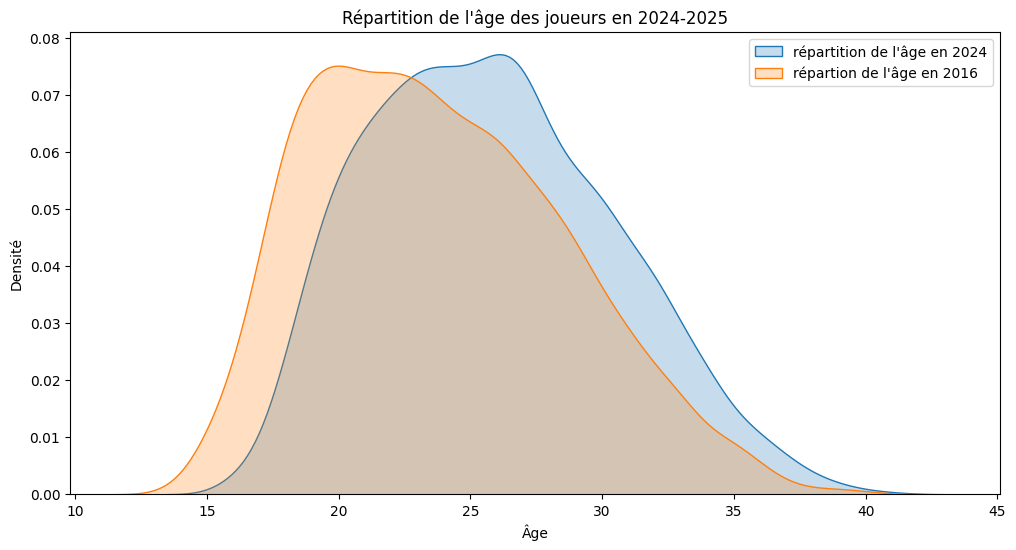

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

age_2024=list(filter(lambda x: type(x)==float,[player_stats_fbref.loc[player,'2024-2025']['age'] for player in player_stats_fbref.index if not(na_player_stats_fbref.loc[player,'2024-2025'])]))
age_2016=list(filter(lambda x: type(x)==float,[player_stats_fbref.loc[player,'2016-2017']['age'] for player in player_stats_fbref.index if not(na_player_stats_fbref.loc[player,'2016-2017'])]))




plt.figure(figsize=(12, 6))
sns.kdeplot(age_2024, fill=True,label="répartition de l'âge en 2024")
sns.kdeplot(age_2016, fill=True,label="répartion de l'âge en 2016")
plt.title('Répartition de l\'âge des joueurs en 2024-2025')
plt.xlabel('Âge')
plt.ylabel('Densité')
plt.legend()
plt.show()

Résultat : On observe sur ce graphique de densité une distribution normale de l'âge des joueurs, centrée en 21 en 2016 et centrée en 26 en 2024. Cela montre le vieillisement moyen des joueurs de foot, ou plutôt la tendance d'aujourd'hui à avoir des carrières plus longues qu'auparavant.

#### Histogramme du nombre de joueurs par championnat

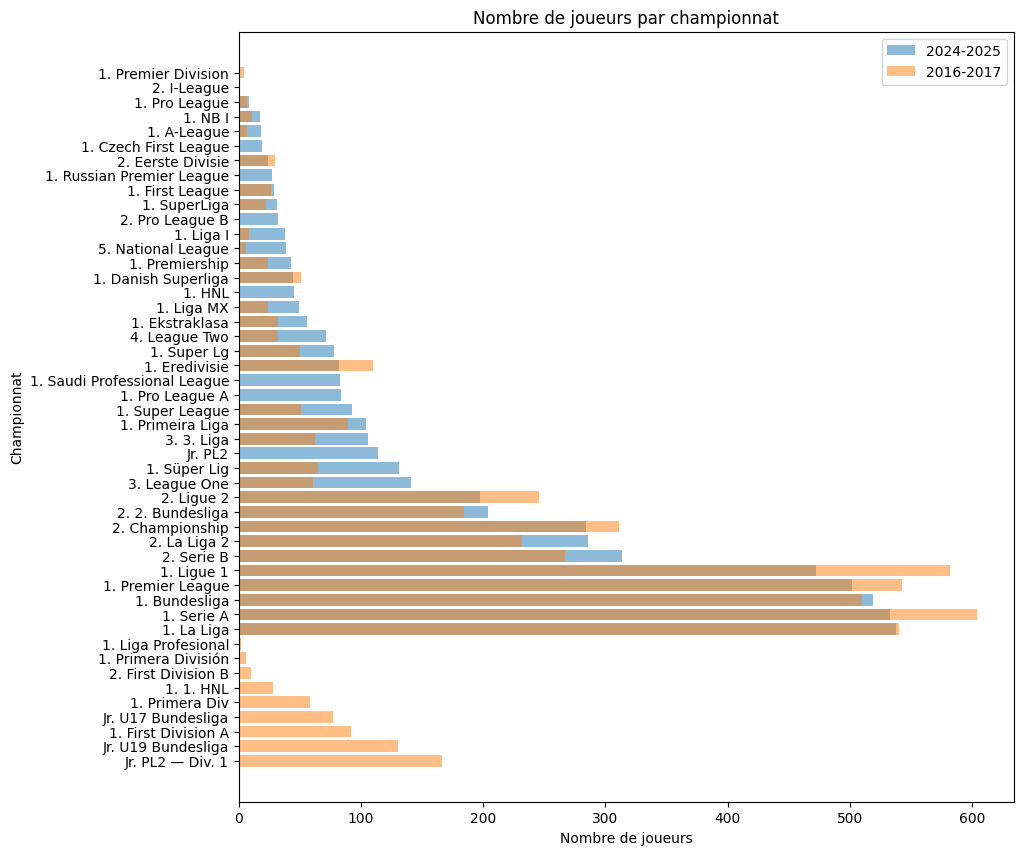

In [4]:
plt.figure(figsize=(10, 10))

for season,color in [('2024-2025','skyblue'),('2016-2017','orange')]:

    champs=[player_stats_fbref.loc[player,season]['comp_level'] for player in player_stats_fbref.index  if not(na_player_stats_fbref.loc[player,season])]

    champ_counts=sorted([(champs.count(champ),champ) for champ in set(champs)])
    champs,champ_counts=[x[1] for x in champ_counts],[x[0] for x in champ_counts]

    

    plt.barh(champs,champ_counts,label=season,alpha=0.5,fill=True)



    

    


# Afficher le graphique

plt.title('Nombre de joueurs par championnat')
plt.xlabel('Nombre de joueurs')
plt.ylabel('Championnat')
plt.legend()
plt.gca().invert_yaxis()  # Inverse l'ordre pour que le championnat avec le plus de joueurs soit en haut
plt.show()

Sans surprise, on retrouve un nombre de joueurs plus important dans les grands championnats européens dû à un meilleur recensement des données.  
Cependant, on observe tout de même une augmentation de 2016 à 2024 du nombre de joueurs pour les championnats les moins connus, ce qui démontre un recensement des données en amélioration. Pour les plus grands championnats c'est l'inverse, ce qui laisse penser à une éventuelle restriction dans le recensement.

## 2. Statistiques d'évaluation de la performance d'un joueur

On cherche désormais à identifier des corrélations entre les variables de statistiques d'un joueur et sa performance, à savoir sa note.

#### Graphique-radar des métriques des joueurs

Pour cela, on se propose de réaliser un "graphique-radar" qui représentera les statistiques d'un joueur et permettra une première comparaison entre joueurs. On considérera uniquement les données sur la saison 24-25.

On commence par normaliser les données en les ramenant sur [0,1].

In [5]:
from tqdm import tqdm

max_dict,min_dict={},{}


features=['npxg_net','shots_on_target','passes_completed','passes_total_distance','assists','through_balls','crosses','xg_assist','passes_blocked','sca','tackles_won','challenges','blocks','interceptions','take_ons_won','carries','carries_distance','fouled','aerials_won']

for feature in tqdm(features):
    feature_list=list(filter(lambda x:type(x)==float,[player_stats_fbref.loc[player,'2024-2025'][feature] for player in player_stats_fbref.index 
                                                      if not(na_player_stats_fbref.loc[player,'2024-2025']) 
                                                      and feature in player_stats_fbref.loc[player,'2024-2025'].keys()
                                                      and player in player_stats_tm.index
                                                      and player_stats_tm.loc[player,'positions']!=[]
                                                      and player_stats_tm.loc[player,'positions'][0]!='Goalkeeper'
                                                      ]))
    
    max_dict[feature],min_dict[feature]=max(feature_list),min(feature_list)


100%|██████████| 19/19 [00:04<00:00,  4.46it/s]


On peut maintenant réaliser notre radar. La fonction radar_plot_players de la cellule ci-dessous permet de réaliser le radar d'une liste de joueurs et de connaître l'aire de ce radar.

In [8]:
import copy
import numpy as np

def radar_plot_players(player_list,year='2024-2025',return_area=False,show_radar=True):   
    "Renvoie soit : un radar graphique avec les différentes métriques des joueur de player_list lors de '2024-2025', ou l'aire de ce radar, et si l'on ne veut pas d'affichage, pour comparer par exemple, on désactive show_radar"
     
    if not(return_area):
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    areas = {}  # Dictionnaire pour stocker les aires des joueurs

    for player in player_list:
        data = copy.deepcopy(player_stats_fbref.loc[player, year])
        
        # Normalisation des données
        
        for feature, value in data.items():
            try:
                data[feature] = (value - min_dict[feature]) / (max_dict[feature] - min_dict[feature])
            except:
                pass
        
        
        data = list(filter(lambda x: isinstance(x[1], float), [(k, v) for k, v in data.items() if k in features]))
        
        labels = [x[0] for x in data]
        stats = [x[1] for x in data]
        
        # Fermer le cercle
        stats += stats[:1]
        labels += labels[:1]
        
        # Calculer l'aire sous le graphique radar
        theta = np.linspace(0, 2 * np.pi, len(stats))
        area = 0.5 * np.abs(np.dot(stats, np.roll(np.sin(theta), 1)) - np.dot(np.roll(stats, 1), np.sin(theta)))
        areas[player] = area
        
        if return_area:
            continue  # Passer au prochain joueur pour collecter toutes les aires sans afficher de graphique
        
        # Tracer le radar pour le joueur actuel
        ax.plot(theta, stats, linewidth=2, label=player)
        ax.fill(theta, stats, alpha=0.2)
    
    if not(return_area):
        # Configuration du graphique après la boucle
        ax.set_xticks(theta[:-1])
        ax.set_xticklabels(labels[:-1], fontsize=10)
        ax.set_yticklabels([])
        ax.set_title('Graphique Radar', size=15, color='darkblue')
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
        
    if show_radar:
        plt.show()
    
    if return_area:
        return areas
    
    

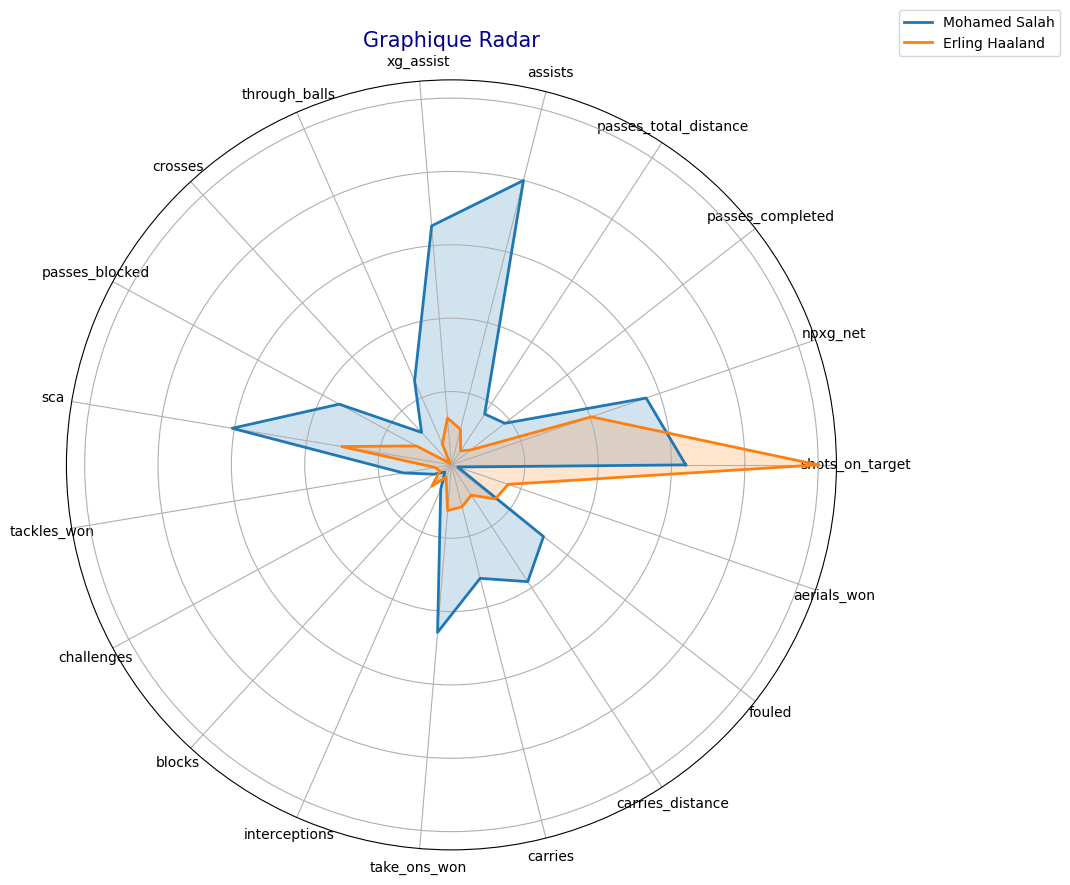

In [9]:
radar_plot_players(['Mohamed Salah','Erling Haaland'])

On a grâce à ce radar une très bonne vision du style d'un joueur à partir de ses statistiques.  
Ici par exemple, on voit que Haaland est un très grand finisseur, lui qui marque beaucoup et tire beaucoup. Mohamed Salah, lui, est un grand finisseur mais aussi un créateur, puisqu'il délivre de nombreuses passes décisives.

#### Exploration d'un lien de corrélation entre l'aire d'un radar et la performance d'un joueur

On souhaite observer si l'aire du radar d'un joueur est un bon indicateur de sa performance.

In [10]:
na_player_ratings=player_ratings.isna()

On exclut les valeurs manquantes et on stocke dans un dictionnaire les notes des joueurs sur la saison 24-25 avant de représenter l'aire du radar en fonction de la note sous la forme d'un nuage de points.

In [11]:
import random
player_ratings_2024=dict([(player,player_ratings.loc[player,'2024-2025']) for player in player_ratings.index if 
                            not(na_player_ratings.loc[player,'2024-2025']) 
                            and not(na_player_stats_fbref.loc[player,'2024-2025'])
                            and player in player_stats_tm.index
                            and player_stats_tm.loc[player,'positions']!=[]
                            and player_stats_tm.loc[player,'positions'][0]!='Goalkeeper'
                                                                                 
                                                                                 ])
ratings=list(player_ratings_2024.values())

areas=list(radar_plot_players(list(player_ratings_2024.keys()),return_area=True,show_radar=False).values())

sample_values=random.sample(list(np.arange(len(areas))),k=100)

Text(0.5, 1.0, 'Aire du radar en fonction de la note du joueur')

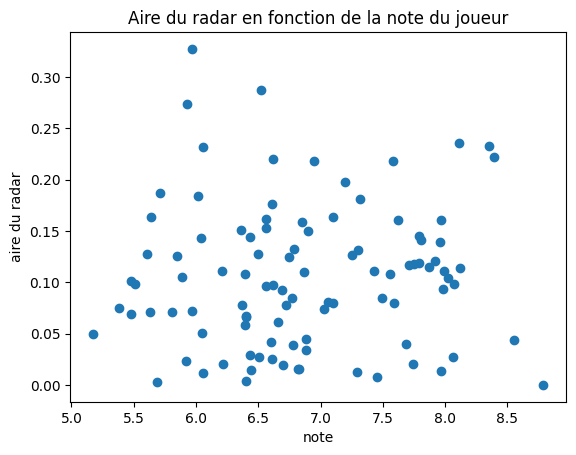

In [12]:
plt.scatter([ratings[i] for i in sample_values],[areas[i] for i in sample_values])
plt.xlabel('note')
plt.ylabel('aire du radar')
plt.title('Aire du radar en fonction de la note du joueur')

Résultat : On observe pas de corrélation immédiate.  
Le radar est un bon outil de visualisation pour comparer et voir directement certaines caractéristiques du jeu d'un joueur, mais il ne donne pas d'indication sur sa note.

## 3. Visualisation des données de transferts

Pour visualiser les données sur les transferts des joueurs ayant été scrapées, on se propose de réaliser une carte interactive à l'aide de la librairie Folium.

In [17]:
import folium
from IPython.display import display
from folium.plugins import AntPath

def get_transfer_value(club,season):
    if club in transfer_history["GB1"][season].keys():
        transfer_fees = {'departures' : [], 'arrivals' : []}
        transfer_fees['arrivals'] = [fee[2]/1000 for fee in transfer_history["GB1"][season][club]["arrivals"] if type(fee[2])==float or type(fee[2])==int]
        for fee in transfer_history["GB1"][season][club]["departures"] :
            if type(fee[2])==float or type(fee[2])==int :
                transfer_fees['departures'].append(fee[2]/1000)
        return transfer_fees
    return {'departures' : [0], 'arrivals' : [0]}

data = pd.read_csv("pl_clubs_latlon.csv")




# Sélectionner la saison ici
season = 2024


center_lat = data['latitude'].mean()
center_lon = data['longitude'].mean()

mymap = folium.Map(location=[center_lat, center_lon], zoom_start=6)
valeur = 4
for _, row in data.iterrows():
    club = row['club_name']
    transferts = get_transfer_value(club, season)
    valeur = round(sum(transferts['departures']) + sum(transferts['arrivals']))
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=valeur/30,  # Rayon pondéré par la valeur marchande des transferts réalisés
        popup=f"{club}: {valeur}M€ \n Départs: {round(sum(transferts['departures']))}M€ \n Arrivées : {round(sum(transferts['arrivals']))}M€",
        color="blue",
        fill=True,
        fill_color="cyan",
        fill_opacity=0.6,
    ).add_to(mymap)
    if club in transfer_history["GB1"][season].keys():
        liste_departs = transfer_history["GB1"][season][club]["departures"]
        liste_arrivees = transfer_history["GB1"][season][club]["arrivals"]
        club_layer = folium.FeatureGroup(name=f"{club}", show=False)


        
        
        
        for transfert in liste_departs:
            if transfert[1] in list(data['club_name']):
                # Départ et arrivée
                depart = (
                    float(data[data['club_name'] == club]['latitude']),
                    float(data[data['club_name'] == club]['longitude']),
                )
                arrivee = (
                    float(data[data['club_name'] == transfert[1]]['latitude']),
                    float(data[data['club_name'] == transfert[1]]['longitude']),
                )
                
                # Ajouter une flèche au layer
                path = AntPath(
                    locations=[depart, arrivee],  # Liste des coordonnées
                    color="red",
                    weight=5,
                    opacity=0.8,
                ).add_to(club_layer)
                path.add_child(folium.Popup(f"Joueur: {transfert[0]} \n {transfert[2]}"))
                club_layer.add_child(path)

        for transfert in liste_arrivees:
            if transfert[1] in list(data['club_name']):
                # Départ et arrivée
                arrivee = (
                    float(data[data['club_name'] == club]['latitude']),
                    float(data[data['club_name'] == club]['longitude']),
                )
                depart = (
                    float(data[data['club_name'] == transfert[1]]['latitude']),
                    float(data[data['club_name'] == transfert[1]]['longitude']),
                )
                
                # Ajouter une flèche au layer
                path = AntPath(
                    locations=[depart, arrivee],  # Liste des coordonnées
                    color="green",
                    weight=5,
                    opacity=0.8,
                ).add_to(club_layer)
                path.add_child(folium.Popup(f"Joueur: {transfert[0]} \n {transfert[2]}"))
                club_layer.add_child(path)

        # Ajouter la couche à la carte
    club_layer.add_to(mymap)    

folium.LayerControl(collapsed=True).add_to(mymap)



# Sauvegarder la carte et l'afficher
mymap.save("carte_interactive.html")
display(mymap)


C:\Users\massi\AppData\Local\Temp\ipykernel_11668\3937779123.py:55: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(data[data['club_name'] == club]['latitude']),
C:\Users\massi\AppData\Local\Temp\ipykernel_11668\3937779123.py:56: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(data[data['club_name'] == club]['longitude']),
C:\Users\massi\AppData\Local\Temp\ipykernel_11668\3937779123.py:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(data[data['club_name'] == transfert[1]]['latitude']),
C:\Users\massi\AppData\Local\Temp\ipykernel_11668\3937779123.py:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.il

Le menu déroulant dans le coin supérieur droit permet la sélection du club.  
En vert sont représentées les arrivées, en rouge les départs. En cliquant sur les flèches on peut voir les infos du transfert.  
Les rayons des cercles des clubs sont pondérés par la valeur marchande des transferts réalisés par le club cette saison-là.  
Par défaut, la carte affiche les transferts de la saison 24-25 mais il est possible de visualiser les transferts des autres saisons en modifiant manuellement dans le notebook la valeur de la variable "season" en haut de la cellule.

# Troisième Partie : Modélisation

## Modèle 1: Outil d'évaluation de performance des joueurs selon leurs métriques

Le but de cette partie sera de construire un modèle qui prendra en entrée les métriques d'un joueur sur une saison, et renvoie en sortie une note prédite

### Input : Vectorisation des données des joueurs

Petit réglage sur les minutes jouées qui n'ont pas pu être interprétées comme des float à cause de ','

In [38]:
def change_minutes_type(entry):
    "Numérise l'entrée associée au minutes jouées"
    try:
        entry['minutes']=float(entry['minutes'].replace(',',''))
        return entry
    except:
        return entry



player_stats_fbref=player_stats_fbref.map(change_minutes_type)

#### Encodage des variables catégoriques

Module utile pour avoir immédiatement un encodage binaire des variables catégorique 

In [4]:
!pip3 install category_encoders


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


Les variables à encoder

In [5]:
[(k,v) for (k,v) in player_stats_fbref.loc['Mohamed Salah','2024-2025'].items() if type(v)==str and v!='']

[('team', 'Liverpool'),
 ('country', 'eng ENG'),
 ('comp_level', '1. Premier League'),
 ('lg_finish', '1st')]

Encodage Binaire pour ne pas avoir de relation d'ordre mais ne pas utiliser trop de mémoire non plus

In [11]:
import category_encoders as ce

encoded_var=['team','country','comp_level','lg_finish']

encoding_table={}

for var in encoded_var:
    
    
    encoder=ce.BinaryEncoder(return_df=False)
    
    
    #extraction des valeurs que peut prendre var
    classes=set()
    years=[f'{2024-i}-{2024-i+1}' for i in range(10)]
    for year in years:
        for player in player_stats_fbref.index:
            if not(na_player_stats_fbref.loc[player,year]):
                classes.add(player_stats_fbref.loc[player,year][var])
    encoder.fit(list(classes))
    
    encoding_table[var]=encoder

Exemple avec le championnat anglais

In [116]:
encoding_table['country'].transform(['eng ENG'])

array([[0, 1, 0, 1, 1, 0]])

#### Extraction de la moyenne et de l'écart type pour les variables non catégoriques afin de normaliser

$\textbf{C'est très important car sinon la loss diverge}$

In [41]:
import numpy as np
from tqdm import tqdm
#Pour fixer la taille de l'input
categories=player_stats_fbref.loc['Mohamed Salah','2024-2025'].keys()

norm_dict={}

# Calculer la moyenne et l'écart-type pour toutes les statistiques
for category in tqdm(categories):
    if category not in encoded_var:
        data=[player_stats_fbref.loc[player,year][category] for player in player_stats_fbref.index for year in seasons if not(na_player_stats_fbref.loc[player,year]) and category in player_stats_fbref.loc[player,year].keys()]
        data=np.array(list(filter(lambda x: type(x)==float,data)))
        mean,std=np.mean(data),np.std(data)
        norm_dict[category]={'mean':mean,'std':std}
        
def normalise(x):
    "normalise les différentes entrées du dictionnaire x"
    for category in categories:
        if category not in encoded_var and type(x)==dict and category in x.keys() and type(x[category])==float:
            mean,std=norm_dict[category]['mean'],norm_dict[category]['std']
            x[category]=(x[category]-mean)/std  
    return x  


        
            

100%|██████████| 147/147 [02:14<00:00,  1.09it/s]


$\textbf{Détail Important: Après avoir appliqué cette fonction, même \textit{player stats bref} est modifié }$

In [42]:
#données normalisées
player_stats_fbref_norm=player_stats_fbref.apply(lambda x:x.apply(normalise))

In [16]:
player_stats_fbref_norm.loc['Mohamed Salah','2024-2025']['goals']

2.9445369988223056

On voit bien que l'échelle est réduite

In [17]:

def vectorize(player,season):
    "Retourne le vecteur encodant la saison season de player"
    data=player_stats_fbref_norm.loc[player,season]
    vect=[]
    for category in categories:
            if category in data.keys() and data[category]!='':
                if category in encoded_var:
                    vect+=list(encoding_table[category].transform([data[category]])[0])
                else:
                    vect+=[data[category]]
            else:
                # l'encodage binaire fait qu'on remplace une information catégorique inconnue par un vecteur de bonne taille avec que des -3 (que le modèle pourra identifier comme inconnue avec proba 99.7 (les statistiques suivent))
                #Une loi N(0,1)
                vect+=[-3]*(1 if category not in encoded_var else len(list(encoding_table[category].transform([player_stats_fbref_norm.loc['Mohamed Salah','2024-2025'][category]])[0])))
            
    return vect


input_size=len(vectorize('Mohamed Salah','2024-2025')) 
vectorize('Mohamed Salah','2024-2025')[:10]

[1.516432869569389, 0, 0, 0, 1, 1, 0, 1, 1, 1]

### Définition du modèle

#### Pour l'architechture du modèle on prend quelque chose de très simple : Un réseau de neurones linéaire , c'est-à-dire un opérateur de la forme $A^T.X + b$ , et on va chercher les coordonées de A et b qui minimisent l'écart moyen quadratique MSE loss de la forme $\frac{\sum{}^{N}{(y_{pred}-y_{réel})^2}}{N}$ par la méthode de descente de gradient

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

model=nn.Linear(input_size,1)
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)


ModuleNotFoundError: No module named 'torch'

In [36]:
import numpy as np
n=len(player_ratings)
random_indexes=np.random.choice(np.arange(n),int(0.8*n),replace=False)

#On sépare bien les données en données d'entraînement et données test

training_data=player_ratings.iloc[random_indexes]
validation_data=player_ratings.iloc[[i for i in np.arange(n) if i not in random_indexes]]

In [37]:
training_data.head()

,2024-2025,2023-2024,2022-2023,2021-2022,2020-2021,2019-2020,2018-2019,2017-2018,2016-2017,2015-2016
Thijs Dallinga,6.35,7.01,7.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nolito,NaN,NaN,NaN,7.63,5.81,7.32,6.58,5.89,7.16,6.97
Theocharis Tsingaras,NaN,NaN,6.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Maximiliano Caufriez,7.46,6.11,6.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Paul Wanner,7.56,NaN,7.12,6.41,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
validation_data.head()

,2024-2025,2023-2024,2022-2023,2021-2022,2020-2021,2019-2020,2018-2019,2017-2018,2016-2017,2015-2016
Riccardo Calafiori,8.45,8.02,NaN,6.04,6.02,5.67,NaN,NaN,NaN,NaN
Leandro Trossard,6.58,6.57,6.00,7.40,7.65,5.82,NaN,NaN,NaN,NaN
Myles Lewis-Skelly,7.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Jordan Ayew,6.65,6.46,5.60,8.12,6.67,7.36,5.53,8.02,7.60,6.36
Odsonne Édouard,5.83,5.55,5.72,5.95,NaN,NaN,NaN,NaN,7.79,NaN


In [39]:
na_validation_data=validation_data.isna()
na_training_data=training_data.isna()

## Entraînement

In [49]:
training_data

,2024-2025,2023-2024,2022-2023,2021-2022,2020-2021,2019-2020,2018-2019,2017-2018,2016-2017,2015-2016
Thijs Dallinga,6.35,7.01,7.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nolito,NaN,NaN,NaN,7.63,5.81,7.32,6.58,5.89,7.16,6.97
Theocharis Tsingaras,NaN,NaN,6.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Maximiliano Caufriez,7.46,6.11,6.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Paul Wanner,7.56,NaN,7.12,6.41,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
Cristian Gamboa,5.34,6.21,7.84,6.65,NaN,NaN,NaN,NaN,NaN,7.67
Wilfried Singo,5.66,8.23,7.64,6.07,7.78,12.00,NaN,NaN,NaN,NaN
Samuel Essende,7.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bryan Oviedo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.84,6.36


In [112]:
loss_tab_training=[]


import random
from tqdm import tqdm

# on itère 10 fois sur les données d'entrainement
for epoch in tqdm(range(10)):
    training_data=training_data.sample(len(training_data))
    for player in training_data.index:
        for season in training_data.columns:
            if not(na_training_data.loc[player,season]) and not(na_player_stats_fbref.loc[player,season]):
                

                    input=torch.Tensor(vectorize(player,season))
                    output=torch.Tensor([training_data.loc[player,season]])
                    
                    # Écart entre la note attendue (réelle) et celle prédite par le modèle
                    prediction=model(input)
                    loss=criterion(output,prediction)
                    
                    loss_tab_training.append(loss)
                    
                    #Descente de gradient sur les paramètres du modèle
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
        
                
                
                

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [09:42<00:00, 58.28s/it]


In [113]:
loss_tab_training=list(map(lambda x:x.item(),loss_tab_training))

On découpe le tableau en 100 et on fais affiche la moyenne des 100 sous-tableaux afin d'avoir un graphique plus clair avec moins de bruit

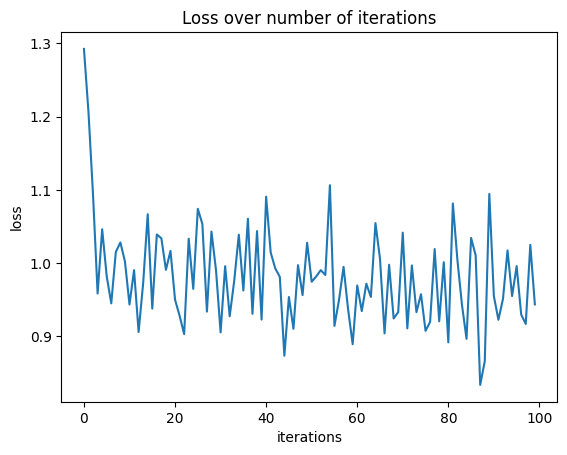

Text(0.5, 1.0, 'Loss after 10th iteration')

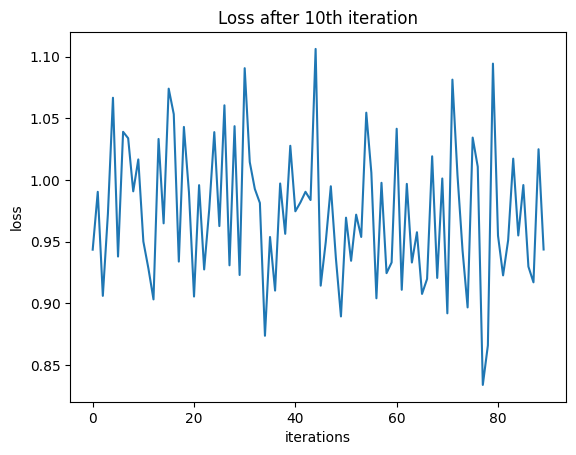

In [114]:
import matplotlib.pyplot as plt

plt.plot([np.average(np.array(l)) for l in np.array_split(np.array(loss_tab_training),100)])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss over number of iterations')
plt.show()
plt.plot([np.average(np.array(l)) for l in np.array_split(np.array(loss_tab_training),100)][10:])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss after 10th iteration')

#### On voit que la loss du modèle converge très rapidement vers plus ou moins 1

## Test

In [115]:
loss_tab_validation=[]

for player in validation_data.index:
        current_loss=[]
        for season in validation_data.columns:
            if not(na_validation_data.loc[player,season]) and not(na_player_stats_fbref.loc[player,season]):
                # Ici on n'effectue pas la descente de gradient étant donné qu'on mesure la performance du modèle
                    input=torch.Tensor(vectorize(player,season))
                    output=torch.Tensor([validation_data.loc[player,season]])
                    prediction=model(input)
                    loss=criterion(output,prediction)
                    loss_tab_validation.append(loss)


In [122]:
lin_model_perf=np.average(list(map(lambda x:x.item(),loss_tab_validation)))
lin_model_perf

0.9113208956380486

In [121]:
m=np.mean([player_ratings.loc[player,season] for player in player_ratings.index for season in player_ratings.columns if not(na_player_ratings.loc[player,season])])
mean_model_perf=np.mean([(m-player_ratings.loc[player,season])**2 for player in player_ratings.index for season in player_ratings.columns if not(na_player_ratings.loc[player,season])])
mean_model_perf

0.8506481358643635

##### On voit que la performance du modèle Linéaire n'est pas très bonne, elle est moins bonne qu'un modèle qui renvoie simplement la moyenne des notes pour chaque entrée

##### On va donc se tourner vers un modèle un peu plus complexe : un MLP (Multi-Layer Perceptron)

## Définition

In [275]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

#Droupout pour éviter l'overfitting
mlp = Sequential([
    Dense(64, activation='relu', input_shape=(input_size,)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1) 
])
mlp.compile(optimizer='adam', loss='mean_squared_error')


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [133]:
x_train=[vectorize(player,season) for player in training_data.index for season in training_data.columns if not(na_player_ratings.loc[player,season]) and not(na_player_stats_fbref.loc[player,season])]
y_train=[player_ratings.loc[player,season] for player in training_data.index for season in training_data.columns if not(na_player_ratings.loc[player,season]) and not(na_player_stats_fbref.loc[player,season])]
x_val=[vectorize(player,season) for player in validation_data.index for season in validation_data.columns if not(na_player_ratings.loc[player,season]) and not(na_player_stats_fbref.loc[player,season])]
y_val=[player_ratings.loc[player,season] for player in validation_data.index for season in validation_data.columns if not(na_player_ratings.loc[player,season]) and not(na_player_stats_fbref.loc[player,season])]

In [276]:


history = mlp.fit(
    np.array(x_train), np.array(y_train),
    epochs=15,
    batch_size=1,
    validation_data=(np.array(x_val),np.array(y_val)),
    verbose=1 #désactiver pour enlever les affichages
)

Epoch 1/15
20133/20133 ━━━━━━━━━━━━━━━━━━━━ 9s 436us/step - loss: 3.2630 - val_loss: 1.3044
Epoch 2/15
20133/20133 ━━━━━━━━━━━━━━━━━━━━ 9s 465us/step - loss: 1.2688 - val_loss: 0.9197
Epoch 3/15
20133/20133 ━━━━━━━━━━━━━━━━━━━━ 10s 477us/step - loss: 0.9721 - val_loss: 0.8825
Epoch 4/15
20133/20133 ━━━━━━━━━━━━━━━━━━━━ 10s 492us/step - loss: 0.8995 - val_loss: 0.9250
Epoch 5/15
20133/20133 ━━━━━━━━━━━━━━━━━━━━ 8s 413us/step - loss: 0.8632 - val_loss: 0.9169
Epoch 6/15
20133/20133 ━━━━━━━━━━━━━━━━━━━━ 9s 438us/step - loss: 0.8557 - val_loss: 0.8764
Epoch 7/15
20133/20133 ━━━━━━━━━━━━━━━━━━━━ 8s 412us/step - loss: 0.8098 - val_loss: 0.8689
Epoch 8/15
20133/20133 ━━━━━━━━━━━━━━━━━━━━ 9s 456us/step - loss: 0.8579 - val_loss: 0.8666
Epoch 9/15
20133/20133 ━━━━━━━━━━━━━━━━━━━━ 10s 481us/step - loss: 0.8199 - val_loss: 0.8667
Epoch 10/15
20133/20133 ━━━━━━━━━━━━━━━━━━━━ 10s 475us/step - loss: 0.8138 - val_loss: 0.8695
Epoch 11/15
20133/20133 ━━━━━━━━━━━━━━━━━━━━ 8s 414us/step - loss: 0.8573 -

##### On voit que le modèle peine malgré tout à dépasser la stratégie qui consiste en renvoyant la moyenne à chaque fois même en prenant une architechture plus robuste, ce qui interroge sur la façon dont les notes sont calculées.

In [280]:
def prediction_note(player,season):
    "Renvoie la prédiction de la note de player lors de season"
    return mlp.predict(np.array([vectorize(player,season)]),verbose=0)[0][0]

prediction_note('Rodri','2023-2024')

8.098294

sauvegarde des paramètres des modèles

In [31]:
torch.save(model.state_dict(),'linear_model.pth')
mlp.save_weights('mlp_weights.weights.h5')
!mkdir models
!mv linear_model.pth mlp_weights.weights.h5 models

## Modèle 2 : Prédiction de la performance d'un joueur 

### Input

On crée un vecteur avec comme informations : Les statisitiques du joueur sur ses dernières saisons, les données de l'équipe dans laquelle il va jouer et les données des éventuels concurrents à son poste

#### Encodage de l'équipe

#####  Mapping rapide pour savoir à quel championnat appartient chaque équipe

In [82]:
champ_mapping={}

for champ,year,team in [(champ,year,team) for champ in championships for year in teams_fbref[champ].keys() for team in teams_fbref[champ][year].keys()]:
    if team not in champ_mapping:
        champ_mapping[team]=champ
        
random.sample(list(champ_mapping.items()),k=10)
        

[('Nürnberg', 'L1'),
 ('Levante', 'ES1'),
 ('Girona', 'ES1'),
 ('Crystal Palace', 'GB1'),
 ('Saint-Étienne', 'FR1'),
 ('Granada', 'ES1'),
 ('Napoli', 'IT1'),
 ('Cádiz', 'ES1'),
 ('Toulouse', 'FR1'),
 ('Bordeaux', 'FR1')]

#### Normalisation des données équipes

On cherche une équipe qui a toutes ses features remplies pour pour fixer la taille de l'entrée

In [83]:
max([(len(global_team_stats_fbref.loc[team,year]),team,year) for team in teams_fbref_list for year in global_team_stats_fbref.columns if not(na_global_team_stats.loc[team,year])])

(182, 'Wolves', '2020-2021')

In [18]:
features=global_team_stats_fbref.loc['Wolves','2020-2021'].keys()

In [22]:
norm_dict_teams={}

for feature in tqdm(features):
        feature_list=[global_team_stats_fbref.loc[team,year][feature] for team in teams_fbref_list for year in global_team_stats_fbref.columns if not(na_global_team_stats.loc[team,year]) and feature in global_team_stats_fbref.loc[team,year].keys()]
        mean,std=np.average(feature_list),np.std(feature_list)
        norm_dict_teams[feature]={'mean':mean,'std':std}

100%|██████████| 182/182 [00:18<00:00,  9.61it/s]


In [23]:
def normalise_team(x):
    try:
        for k,v in x.items():
            x[k]=(x[k]- norm_dict_teams[k]['mean'])/(1 if norm_dict_teams[k]['std']==0 else norm_dict_teams[k]['std'])
        return x
    except:
        return x
norm_global_team_stats_fbref=global_team_stats_fbref.copy(deep=True)
norm_global_team_stats_fbref.apply(lambda x:x.apply(normalise_team))

,2024-2025,2023-2024,2022-2023,2021-2022,2020-2021,2019-2020,2018-2019,2017-2018,2016-2017,2015-2016
Liverpool,"{'age': 0.7929841916730952, 'gk_games': -2.809...","{'age': -0.21286089099984537, 'gk_games': 0.48...","{'age': 0.7091637681170156, 'gk_games': 0.4803...","{'age': 0.9606250387852515, 'gk_games': 0.4803...","{'age': 0.2062412267805468, 'gk_games': 0.4803...","{'age': 0.03860037966839053, 'gk_games': 0.480...","{'age': -0.3805017381120016, 'gk_games': 0.480...","{'age': -0.7996038558923938, 'gk_games': 0.480...","{'age': -0.3805017381120016, 'gk_games': 0.480...","{'age': -1.1348855501167092, 'gk_games': 0.480..."
Chelsea,"{'age': -2.14073063278965, 'gk_games': -2.6532...","{'age': -1.9730897856774936, 'gk_games': 0.480...","{'age': -0.21286089099984537, 'gk_games': 0.48...","{'age': 0.7091637681170156, 'gk_games': 0.4803...","{'age': -0.46432216166808127, 'gk_games': 0.48...","{'age': -0.8834242794484735, 'gk_games': 0.480...","{'age': 0.625343344560939, 'gk_games': 0.48039...","{'age': 0.12242080322446718, 'gk_games': 0.480...","{'age': 0.5415229210048593, 'gk_games': 0.4803...","{'age': 0.2062412267805468, 'gk_games': 0.4803..."
Arsenal,"{'age': -0.1290404674437687, 'gk_games': -2.80...","{'age': -1.3025263972288657, 'gk_games': 0.480...","{'age': -1.5539876678971014, 'gk_games': 0.480...","{'age': -1.8054489385653374, 'gk_games': 0.480...","{'age': -0.5481425852241609, 'gk_games': 0.480...","{'age': -0.6319630087802375, 'gk_games': 0.480...","{'age': 0.12242080322446718, 'gk_games': 0.480...","{'age': 0.2062412267805468, 'gk_games': 0.4803...","{'age': 0.29006165033662346, 'gk_games': 0.480...","{'age': 0.37388207389270306, 'gk_games': 0.480..."
Nott'ham Forest,"{'age': 0.29006165033662346, 'gk_games': -2.65...","{'age': -0.7157834323363171, 'gk_games': 0.480...","{'age': -0.0452200438876891, 'gk_games': 0.480...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
Manchester City,"{'age': 0.9606250387852515, 'gk_games': -2.653...","{'age': 0.03860037966839053, 'gk_games': 0.480...","{'age': 0.5415229210048593, 'gk_games': 0.4803...","{'age': 0.37388207389270306, 'gk_games': 0.480...","{'age': -0.3805017381120016, 'gk_games': 0.480...","{'age': 0.29006165033662346, 'gk_games': 0.480...","{'age': 0.12242080322446718, 'gk_games': 0.480...","{'age': -0.1290404674437687, 'gk_games': 0.480...","{'age': 1.6311884272338795, 'gk_games': 0.4803...","{'age': 1.4635475801217233, 'gk_games': 0.4803..."
...,...,...,...,...,...,...,...,...,...,...
Paderborn 07,NaN,NaN,NaN,NaN,NaN,"{'age': -0.7157834323363171, 'gk_games': -0.14...",NaN,NaN,NaN,NaN
Hannover 96,NaN,NaN,NaN,NaN,NaN,NaN,"{'age': -0.21286089099984537, 'gk_games': -0.1...","{'age': -0.1290404674437687, 'gk_games': -0.14...",NaN,"{'age': -0.7996038558923938, 'gk_games': -0.14..."
Nürnberg,NaN,NaN,NaN,NaN,NaN,NaN,"{'age': -1.3863468207849452, 'gk_games': -0.14...",NaN,NaN,NaN
Hamburger SV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'age': -1.3025263972288657, 'gk_games': -0.14...","{'age': -0.6319630087802375, 'gk_games': -0.14...","{'age': 0.4577024974487827, 'gk_games': -0.146..."


In [25]:
random.sample(list(norm_global_team_stats_fbref.loc['Liverpool','2022-2023'].items()),k=10)

[('through_balls', 2.370240670863786),
 ('corner_kicks', 1.3222053647278829),
 ('age', 0.7091637681170156),
 ('shots_on_target_per90', 1.000432483807645),
 ('sca_shots', 1.8732917870479353),
 ('gca_passes_live', 1.4663442159620947),
 ('gk_corner_kick_goals_against', -1.919943202816301),
 ('take_ons_tackled', 0.5151328162515922),
 ('passes_progressive_distance', 1.5176442443631701),
 ('challenge_tackles', 0.6206483266943253)]

#### Encodage rapide du championnat

In [28]:
champ_encoder=ce.BinaryEncoder(return_df=False)

champ_encoder.fit(list(championships.keys()))





def vectorize_team(team,season):
    "Encode les données de team lors de season"
    #Car cette équipe a bien toutes les statistiques remplies

    try:
        vect=list(champ_encoder.transform([champ_mapping[team]])[0])
    except:
        vect=[-3,-3,-3]
    
    
    
    
    #Si jamais l'équipe n'a pas d'entrée pour la saison
    try:
        
        data=norm_global_team_stats_fbref.loc[team,f'{season}-{season+1}']
        #Pour déclencher une erreur si ce n'est pas un dictionnaire (ie pas d'entrée)
        len(data)
    except:
        return vect+[-3]*len(features)
    
    for feature in features:
        
        if feature in data.keys():
            vect.append(data[feature])
        else:
            vect.append(-3)
    return vect


rand_team=random.sample(teams_fbref_list,k=1)[0]

rand_team,vectorize_team(rand_team,2019)[:10]

    
    

('Atlético Madrid',
 [-3,
  -3,
  -3,
  -0.3805017381120016,
  0.4803937979418115,
  0.4803937979418115,
  0.48081851745120135,
  0.4803937979418115,
  -1.3556488775249953,
  -1.7964850712260272])

In [29]:
def big_vectorize(player,season,team):
    "Construit l'input du modèle de prédiction de la performance de player lors de season si il joue dans team"
    
    #On prédit la performance lors de season donc on se base sur l'information jusqu'à la saison  season-1
    season=season-1
    
    
    # Encodage de l'historique du joueur
    vect=[]
    player_vector=[]
    for past_season in range(2015,season+1):
        if not(na_player_stats_fbref.loc[player,f'{past_season}-{past_season+1}']):
            player_vector+=vectorize(player,f'{past_season}-{past_season+1}')
        else:
            player_vector+=[-3]*input_size
    vect=player_vector+[-3]*(input_size)*(2024-season-1)
    
    vect+=vectorize_team(team,season)
    
    
    try:
        player_positions=player_stats_tm.loc[player,'positions']
    except:
        player_positions=[]
    
    
    #on cherche les potentiels concurrents au poste en triant par ceux qui ont la plus haute valeur marchande et on les encode
    
    season_format=f'{season}-{season+1}'
    competitors=sorted([player for player in player_stats_fbref.index if 
                        not(na_player_stats_fbref.loc[player,season_format]) and 
                        player_stats_fbref.loc[player,season_format]['team']==team and player in player_stats_tm.index  and 
                        set(player_positions) & set(player_stats_tm.loc[player,'positions'])]
                       ,key=lambda x:player_stats_tm.loc[x,'market_values'].get(str(season),0),reverse=True)[:2]
    


    

    for competitor in competitors:
        vect+=vectorize(competitor,season_format)
        
    
    #Si jamais il n'y a qu'un ou 0 competiteurs
    if len(competitors)<2:
        vect+=[-3]*input_size*(2-len(competitors))
    
    
    return vect
    
    
    
    

    

    
    
    

In [30]:
big_vectorize('Iago Aspas',2020,'Real Madrid') [:10]

[0.4947370198955811, 0, 0, 0, 1, 1, 1, 0, 0, 0]

On peut retirer ces colonnes car elles correspondent à des saisons jouées en dehors de l'Europe comme les États-Unis ou l'Amérique du Sud, ce qui ne nous intéresse pas

In [31]:
player_stats_fbref.drop([col for col in player_stats_fbref.columns if col!='meta' and '-' not in col],axis=1,inplace=True)


In [33]:
player_stats_fbref.columns

Index(['meta', '2024-2025', '2023-2024', '2022-2023', '2021-2022', '2020-2021',
       '2019-2020', '2018-2019', '2017-2018', '2016-2017', '2015-2016',
       '2014-2015', '2013-2014', '2012-2013', '2011-2012', '2010-2011',
       '2009-2010', '2008-2009', '2007-2008', '2006-2007', '2005-2006',
       '2004-2005', '2003-2004', '2002-2003', '2001-2002', '2000-2001',
       '1999-2000', '1998-1999', '1997-1998', '1996-1997', '1995-1996',
       '1994-1995', '1993-1994', '1992-1993'],
      dtype='object')

In [290]:
data=[]
# On exclut la dernière saison car on ne peut pas prédire le futur
#On prend un échantillon de taille 20 000 car on a environ 2 000 features (une bonne règle est d'avoir au moins 10x le nombre de features en jeu de données)
for player,year in tqdm(random.sample([(player,year) for player in player_stats_fbref.index for year  in years[1:]],k=20000)):
    season=seasons[years.index(year)]
    next_season=seasons[seasons.index(season) - 1]
    if not(na_player_stats_fbref.loc[player,season]) and not(na_player_stats_fbref.loc[player,next_season]):
        team=player_stats_fbref.loc[player,next_season]['team']
        data.append((np.array(big_vectorize(player,year+1,team)),np.array(vectorize(player,next_season))))
        

100%|██████████| 20000/20000 [17:35<00:00, 18.95it/s]


In [306]:
inp,out=np.array([x[0] for x in data]),np.array([x[1] for x in data])

In [ ]:
!pip3 install xgboost
!brew install libomp

In [386]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

params = {
    'objective': 'reg:squarederror',
    'max_depth': 7,
    'learning_rate': 0.1,
    'eval_metric': 'rmse'
}

inp_train, inp_val, out_train, out_val = train_test_split(inp, out, test_size=0.2, random_state=42)

train=xgb.DMatrix(inp_train,label=out_train)
val=xgb.DMatrix(inp_val,label=out_val)


evals_result={}

xg_model = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=15,
    evals=[(train, 'train'), (val, 'validation')],
    evals_result=evals_result,
    early_stopping_rounds=3,  # Arrêt si pas d'amélioration après 3 itérations
    verbose_eval=1,
    xgb_model=xg_model #si il y a déja un cycle d'entraînement qui a été fait
)

[0]	train-rmse:1.01300	validation-rmse:1.08579
[1]	train-rmse:0.98237	validation-rmse:1.06562
[2]	train-rmse:0.95463	validation-rmse:1.04833
[3]	train-rmse:0.92999	validation-rmse:1.03380
[4]	train-rmse:0.90746	validation-rmse:1.02127
[5]	train-rmse:0.88713	validation-rmse:1.01077
[6]	train-rmse:0.86868	validation-rmse:1.00164
[7]	train-rmse:0.85175	validation-rmse:0.99377
[8]	train-rmse:0.83643	validation-rmse:0.98729
[9]	train-rmse:0.82233	validation-rmse:0.98181
[10]	train-rmse:0.80927	validation-rmse:0.97698
[11]	train-rmse:0.79728	validation-rmse:0.97271
[12]	train-rmse:0.78622	validation-rmse:0.96913
[13]	train-rmse:0.77595	validation-rmse:0.96595
[14]	train-rmse:0.76627	validation-rmse:0.96315


##### On a une RMSE qui arrive à passer le seuil de 1: ce qui est la RMSE lorsque l'on prédit 0 pour toutes les entrées (car les métriques suivent des $\mathcal{N}(0,1)$ )

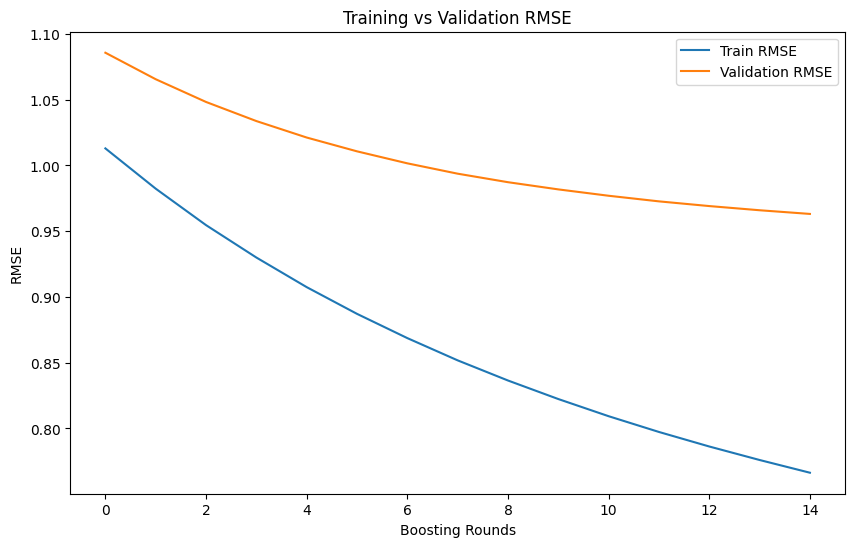

In [388]:
import matplotlib.pyplot as plt


train_rmse = evals_result['train']['rmse']
val_rmse = evals_result['validation']['rmse']


plt.figure(figsize=(10, 6))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Training vs Validation RMSE')
plt.legend()
plt.show()

In [44]:
import xgboost as xgb
len(xg_model.predict(xgb.DMatrix(np.array([big_vectorize('Mohamed Salah',2024,'Liverpool')])))[0])

172

Besoin d'un mapping pour savoir à quel nombre correpond quel statistique

In [56]:
mapping={}
i=0
vect=vectorize('Mohamed Salah','2024-2025')
for category in categories:
    if category not in encoded_var:
        while(i<len(vect) and vect[i] in [0.,1.]):
            i+=1
        mapping[category]=i
        i+=1

In [60]:
list(mapping.items())[:10]

[('age', 0),
 ('minutes_90s', 30),
 ('goals', 31),
 ('shots', 32),
 ('shots_on_target', 33),
 ('shots_on_target_pct', 34),
 ('shots_per90', 35),
 ('shots_on_target_per90', 36),
 ('goals_per_shot', 37),
 ('goals_per_shot_on_target', 38)]

In [72]:
def predict_performance(player,season,team):
    pred=xg_model.predict(xgb.DMatrix(np.array([big_vectorize(player,season,team)])))[0]
    
    res={}
    for category in mapping.keys():
        i = mapping[category]
        #dénormalisation
        res[category]=pred[i]*norm_dict[category]['std'] + norm_dict[category]['mean']
    
    return res
        
list(predict_performance('Cristiano Ronaldo',2018,'Manchester United').items())[:10]
     

[('age', 32.00023224662777),
 ('minutes_90s', 21.754462134366065),
 ('goals', 10.498236014337994),
 ('shots', 1.5162157718191338),
 ('shots_on_target', 7.195437626074675),
 ('shots_on_target_pct', 12.092118881473759),
 ('shots_per90', 0.4665076824285824),
 ('shots_on_target_per90', 0.0036939081170460075),
 ('goals_per_shot', 0.01971003698564046),
 ('goals_per_shot_on_target', 0.109302167708976)]